In [1]:
import os
import re
import sys
import time
import pickle
import math
import random
import string
import collections
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 0
print(device)

cuda


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root=' ', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root=' ', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=1)

0it [00:00, ?it/s]

170500096it [00:06, 27760600.85it/s]                               


Extracting  /cifar-10-python.tar.gz to  
Files already downloaded and verified


In [0]:
class NetWithoutNorm(nn.Module):
  def __init__(self):
    super(NetWithoutNorm,self).__init__()
    self.conv1 = nn.Conv2d(3,96,3,1,1)
    self.conv2 = nn.Conv2d(96,96,3,1,1)
    self.conv3 = nn.Conv2d(96,96,3,1,1)

    self.conv4 = nn.Conv2d(96,192,3,1,1)
    self.conv5 = nn.Conv2d(192,192,3,1,1)
    self.conv6 = nn.Conv2d(192,192,3,1)

    self.conv7 = nn.Conv2d(192,192,3,1)
    self.conv8 = nn.Conv2d(192,192,1,1)
    self.conv9 = nn.Conv2d(192,10,1,1)

    self.pool1 = nn.MaxPool2d((3,3),2)
    self.pool2 = nn.MaxPool2d((3,3),2)
    self.pool3 = nn.AvgPool2d((4,4),1)

    self.fc = nn.Linear(10,10)

  def forward(self,x):
    x = F.dropout2d(x)
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))
    out = F.dropout2d(out)
    out = self.pool1(out)
    out = F.relu(self.conv4(out))
    out = F.relu(self.conv5(out))
    out = F.relu(self.conv6(out))
    out = F.dropout2d(out)
    out = self.pool2(out)
    out = F.relu(self.conv7(out))
    out = F.relu(self.conv8(out))
    out = F.relu(self.conv9(out))
    out = self.pool3(out)
    out = torch.flatten(out,1)
    out = self.fc(out)
    return out

In [0]:
model = NetWithoutNorm().to(device) 

In [24]:
p = torch.ones(1,3,32,32).to(device)
p = model(p)
print(p.size())

torch.Size([1, 10])


In [0]:
class NetBatchNorm(nn.Module):
  def __init__(self):
    super(NetBatchNorm,self).__init__()
    self.conv1 = nn.Conv2d(3,96,3,1,1)
    self.conv2 = nn.Conv2d(96,96,3,1,1)
    self.conv3 = nn.Conv2d(96,96,3,1,1)

    self.conv4 = nn.Conv2d(96,192,3,1,1)
    self.conv5 = nn.Conv2d(192,192,3,1,1)
    self.conv6 = nn.Conv2d(192,192,3,1)

    self.conv7 = nn.Conv2d(192,192,3,1)
    self.conv8 = nn.Conv2d(192,192,1,1)
    self.conv9 = nn.Conv2d(192,10,1,1)

    self.pool1 = nn.MaxPool2d((3,3),2)
    self.pool2 = nn.MaxPool2d((3,3),2)
    self.pool3 = nn.AvgPool2d((4,4),1)

    self.fc = nn.Linear(10,10)

    self.bn1 = nn.BatchNorm2d(96)
    self.bn2 = nn.BatchNorm2d(96)
    self.bn3 = nn.BatchNorm2d(96)
    self.bn4 = nn.BatchNorm2d(192)
    self.bn5 = nn.BatchNorm2d(192)
    self.bn6 = nn.BatchNorm2d(192)
    self.bn7 = nn.BatchNorm2d(192)
    self.bn8 = nn.BatchNorm2d(192)
    self.bn9 = nn.BatchNorm2d(10)
  
  def forward(self,x):
    x = F.dropout2d(x)
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = F.relu(self.bn3(self.conv3(out)))
    out = F.dropout2d(out)
    out = self.pool1(out)
    out = F.relu(self.bn4(self.conv4(out)))
    out = F.relu(self.bn5(self.conv5(out)))
    out = F.relu(self.bn6(self.conv6(out)))
    out = F.dropout2d(out)
    out = self.pool2(out)
    out = F.relu(self.bn7(self.conv7(out)))
    out = F.relu(self.bn8(self.conv8(out)))
    out = F.relu(self.bn9(self.conv9(out)))
    out = self.pool3(out)
    out = torch.flatten(out,1)
    out = self.fc(out)
    return out

In [0]:
class RMSNorm(nn.Module):
  def __init__(self,size,epsilon=1e-6,isbias=False):
    super(RMSNorm,self).__init__()
    self.size = size
    self.epsilon = epsilon
    self.isbias = isbias
    self.gain = nn.Parameter(torch.rand(self.size))
    self.register_parameter("gain", self.gain)
    if(self.isbias):
      self.b = nn.Parameter(torch.zeros(self.size))
      self.register_parameter("bias",self.b)
  def forward(self,x):
    if(x.ndim>3):
      _,c,h,w = x.size()
      rms_x = torch.mean(x**2,dim=(2,3),keepdim=True)
      norm_x = x/(torch.sqrt(rms_x + self.epsilon))
      norm_x = norm_x.view(-1,h,w,c)
      if(self.isbias):
        norm_x = norm_x * self.gain + self.b
      else:
        norm_x = norm_x * self.gain
      norm_x = norm_x.view(-1,c,h,w)
      return norm_x
    else:
      rms = math.sqrt(1./self.size) * torch.norm(x,-1,keepdim=True)
      norm_x = (x/(rms + self.epsilon))
      if(self.isbias):
        norm_x = norm_x * self.gain + self.b
      else:
        norm_x = norm_x * self.gain
      return norm_x

In [0]:
class NetRMSNorm(nn.Module):
  def __init__(self):
    super(NetRMSNorm,self).__init__()
    self.conv1 = nn.Conv2d(3,96,3,1,1)
    self.conv2 = nn.Conv2d(96,96,3,1,1)
    self.conv3 = nn.Conv2d(96,96,3,1,1)

    self.conv4 = nn.Conv2d(96,192,3,1,1)
    self.conv5 = nn.Conv2d(192,192,3,1,1)
    self.conv6 = nn.Conv2d(192,192,3,1)

    self.conv7 = nn.Conv2d(192,192,3,1)
    self.conv8 = nn.Conv2d(192,192,1,1)
    self.conv9 = nn.Conv2d(192,10,1,1)

    self.pool1 = nn.MaxPool2d((3,3),2)
    self.pool2 = nn.MaxPool2d((3,3),2)
    self.pool3 = nn.AvgPool2d((4,4),1)

    self.fc = nn.Linear(10,10)

    self.rn1 = RMSNorm(96)
    self.rn2 = RMSNorm(96)
    self.rn3 = RMSNorm(96)
    self.rn4 = RMSNorm(192)
    self.rn5 = RMSNorm(192)
    self.rn6 = RMSNorm(192)
    self.rn7 = RMSNorm(192)
    self.rn8 = RMSNorm(192)
    self.rn9 = RMSNorm(10)
  
  def forward(self,x):
    x = F.dropout2d(x)
    out = F.relu(self.rn1(self.conv1(x)))
    out = F.relu(self.rn2(self.conv2(out)))
    out = F.relu(self.rn3(self.conv3(out)))
    out = F.dropout2d(out)
    out = self.pool1(out)
    out = F.relu(self.rn4(self.conv4(out)))
    out = F.relu(self.rn5(self.conv5(out)))
    out = F.relu(self.rn6(self.conv6(out)))
    out = F.dropout2d(out)
    out = self.pool2(out)
    out = F.relu(self.rn7(self.conv7(out)))
    out = F.relu(self.rn8(self.conv8(out)))
    out = F.relu(self.rn9(self.conv9(out)))
    out = self.pool3(out)
    out = torch.flatten(out,1)
    out = self.fc(out)
    return out

In [0]:
def evaluate(net,loader):
  correct = 0.0
  total = 0.0
  curloss = 0.0
  with torch.no_grad():
    net.eval()
    for images,labels in loader:
      images, labels = images.to(device), labels.to(device)
      output = net(images)
      l = F.cross_entropy(output,labels)
      output = torch.argmax(output,1)
      total+=output.size(0)
      correct+=(output==labels).sum().item()
      curloss+=l.item()

    curloss = curloss/total
    acc = (correct/total) * 100
    return round(curloss,4),round(acc,3)

In [0]:
numepochs = 200

In [31]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

model1_train_loss = []
model1_train_acc = []
model1 = NetWithoutNorm().to(device)
optim1 = optim.Adam(model1.parameters(),lr=0.0003)
model1.train()
print("Training Without Normalization ")
print("------------------------------------------------------------------------------")
for epoch in range(1,numepochs+1):
  model1.train()
  for images,labels in trainloader:
    images,labels = images.to(device),labels.to(device)
    model1.zero_grad()
    output = model1(images)
    loss = F.cross_entropy(output,labels)
    loss.backward()
    optim1.step()

  curtrainloss, curtrainacc = evaluate(model1,trainloader)
  if(epoch%10==0):
    print("Epoch {} Train Loss {} Train Accuracy {} ".format(epoch,curtrainloss,curtrainacc))
  model1_train_loss.append(curtrainloss)
  model1_train_acc.append(curtrainacc)

curtestloss, curtestacc = evaluate(model1,testloader)
print("Model 1 (Without Normalization) Test Accuracy {} ".format(curtestacc))
print("------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------")
print("Training With Batch Normalization ")
model2_train_loss = []
model2_train_acc = []
model2 = NetBatchNorm().to(device)
optim2 = optim.Adam(model2.parameters(),lr=0.003)
model2.train()
for epoch in range(1,numepochs+1):
  model2.train()
  for images,labels in trainloader:
    images,labels = images.to(device),labels.to(device)
    model2.zero_grad()
    output = model2(images)
    loss = F.cross_entropy(output,labels)
    loss.backward()
    optim2.step()

  curtrainloss, curtrainacc = evaluate(model2,trainloader)
  if(epoch%10==0):
    print("Epoch {} Train Loss {} Train Accuracy {} ".format(epoch,curtrainloss,curtrainacc))
  model2_train_loss.append(curtrainloss)
  model2_train_acc.append(curtrainacc)

curtestloss, curtestacc = evaluate(model2,testloader)
print("Model 2 (With Batch Normalization) Accuracy {} ".format(curtestacc))
print("------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------")
print("Training With RMS Normalization ")
model3_train_loss = []
model3_train_acc = []
model3 = NetRMSNorm().to(device)
optim3 = optim.Adam(model3.parameters(),lr=0.003)
model3.train()
for epoch in range(1,numepochs+1):
  model3.train()
  for images,labels in trainloader:
    images,labels = images.to(device),labels.to(device)
    model3.zero_grad()
    output = model3(images)
    loss = F.cross_entropy(output,labels)
    loss.backward()
    optim3.step()

  curtrainloss, curtrainacc = evaluate(model3,trainloader)
  if(epoch%10==0):
    print("Epoch {} Train Loss {} Train Accuracy {} ".format(epoch,curtrainloss,curtrainacc))
  model3_train_loss.append(curtrainloss)
  model3_train_acc.append(curtrainacc)

curtestloss, curtestacc = evaluate(model3,testloader)
print("Model 3 (With RMS Normalization) Accuracy {} ".format(curtestacc))

Training Without Normalization 
------------------------------------------------------------------------------
Epoch 10 Train Loss 0.0125 Train Accuracy 54.932 
Epoch 20 Train Loss 0.0097 Train Accuracy 65.032 
Epoch 30 Train Loss 0.0085 Train Accuracy 69.412 
Epoch 40 Train Loss 0.0077 Train Accuracy 72.248 
Epoch 50 Train Loss 0.0068 Train Accuracy 75.232 
Epoch 60 Train Loss 0.0064 Train Accuracy 76.346 
Epoch 70 Train Loss 0.006 Train Accuracy 77.772 
Epoch 80 Train Loss 0.0056 Train Accuracy 79.41 
Epoch 90 Train Loss 0.0054 Train Accuracy 79.764 
Epoch 100 Train Loss 0.0052 Train Accuracy 80.652 
Epoch 110 Train Loss 0.0049 Train Accuracy 81.794 
Epoch 120 Train Loss 0.0047 Train Accuracy 82.534 
Epoch 130 Train Loss 0.0046 Train Accuracy 82.852 
Epoch 140 Train Loss 0.0046 Train Accuracy 82.874 
Epoch 150 Train Loss 0.0045 Train Accuracy 83.26 
Epoch 160 Train Loss 0.0043 Train Accuracy 83.63 
Epoch 170 Train Loss 0.0043 Train Accuracy 83.798 
Epoch 180 Train Loss 0.0043 Train A

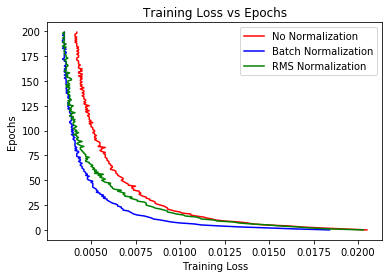

In [35]:
iterations = list(range(numepochs))
plt.plot(model1_train_loss, iterations, 'r', label='No Normalization') # plotting model1 train loss separately 
plt.plot(model2_train_loss, iterations, 'b', label='Batch Normalization') # plotting model2 train loss separately 
plt.plot(model3_train_loss, iterations, 'g', label='RMS Normalization') # plotting model3 train loss separately 
plt.xlabel('Training Loss')
plt.ylabel('Epochs')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

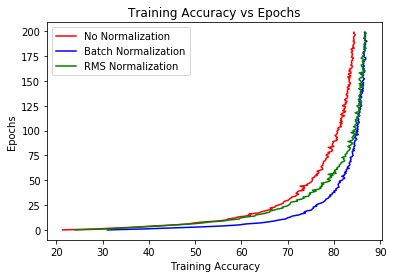

In [36]:
plt.plot(model1_train_acc, iterations, 'r', label='No Normalization') # plotting model1 train accuracy separately 
plt.plot(model2_train_acc, iterations, 'b', label='Batch Normalization') # plotting model2 train accuracy separately 
plt.plot(model3_train_acc, iterations, 'g', label='RMS Normalization') # plotting model3 train accuracy separately 
plt.legend()
plt.xlabel('Training Accuracy')
plt.ylabel('Epochs')
plt.title('Training Accuracy vs Epochs')
plt.show()